In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
# GPU 사용 가능 여부 확인 -> GPU or CPU 선택

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [12]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor()])

In [13]:
# 데이터 준비 2.
train_dataset = datasets.CIFAR10(root="data-files",
                               train=True,
                               download=True,
                               # transform=transforms.ToTensor(),
                               transform=transform)

test_dataset = datasets.CIFAR10(root="data-files",
                              train=False,
                              download=True,
                              # transform=transforms.ToTensor(),
                              transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# 데이터 준비 3.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

In [15]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


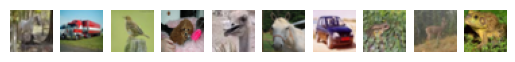

tensor([7, 9, 2, 5, 2, 7, 1, 6, 4, 6])

In [16]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].permute(1, 2, 0))
plt.show()
y[:10]

In [17]:
# 모델 구조 설계

class Cifar10Cnn(nn.Module):
    def __init__(self):
        super(Cifar10Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)        

        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [18]:
# 학습 도구 구성
model = Cifar10Cnn().to(device)
# loss = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

Cifar10Cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [19]:
# 훈련 함수 정의 (학습 설계)
def train(model, train_loader, optimizer):
    model.train() # train mode로 설정
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 300 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [20]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # evaluation mode로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad(): # 가중치 업데이트 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= ( len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy



In [21]:
# 학습 실행

for epoch in range(10):    
    train(model, train_loader, optimizer)
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss: {loss}, Accuracy : {accuracy}")

    

Batch : 0, Loss : 2.3024256229400635
Batch : 300, Loss : 2.0964906215667725
Batch : 600, Loss : 2.129270315170288
Batch : 900, Loss : 2.2481110095977783
Batch : 1200, Loss : 2.0765624046325684
Batch : 1500, Loss : 2.2399678230285645
Epoch : 1, Loss: 2.134214617919922, Accuracy : 0.3197
Batch : 0, Loss : 2.0708277225494385
Batch : 300, Loss : 2.1225507259368896
Batch : 600, Loss : 2.1121103763580322
Batch : 900, Loss : 2.1703851222991943
Batch : 1200, Loss : 2.0803258419036865
Batch : 1500, Loss : 2.1953420639038086
Epoch : 2, Loss: 2.080657823562622, Accuracy : 0.3739
Batch : 0, Loss : 2.014305353164673
Batch : 300, Loss : 1.9518804550170898
Batch : 600, Loss : 2.1123197078704834
Batch : 900, Loss : 1.958831548690796
Batch : 1200, Loss : 2.0417163372039795
Batch : 1500, Loss : 2.075164556503296
Epoch : 3, Loss: 2.0327454391479494, Accuracy : 0.4278
Batch : 0, Loss : 2.1159844398498535
Batch : 300, Loss : 2.017561674118042
Batch : 600, Loss : 1.9659769535064697
Batch : 900, Loss : 2.068

In [29]:
def debug_test():
    print("debug_test")
    print("debug_test2")
    print("debug_test3")

In [30]:
print("start debugging")
debug_test()
evaluate(model, test_loader)

start debugging
debug_test
debug_test2
debug_test3


KeyboardInterrupt: 